In [58]:
# Imports
# Geometry
from shapely.geometry import Point
from shapely.geometry import Polygon
from geopy.distance import distance
from geopy.distance import geodesic
from shapely.wkt import loads

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import folium

# Projections
import pyproj

# Data handling
import geopandas as gpd
import pandas as pd
import numpy as np
import ast
from pandas.io.json import json_normalize

# Network
import requests
import time
import osmnx as ox
import sklearn
import networkx as nx


### DATA PREPARATION

In [43]:
# Lectura de archivos
BOTA = pd.read_csv('LABOTA_POI.csv', sep='|')
BOTA['zona_estudio'] = 'LA BOTA'
TOCTIUCO = pd.read_csv('TOCTIUCO_POI.csv', sep='|')
TOCTIUCO['zona_estudio'] = 'TOCTIUCO'

# Juntar las zonas de interes en una sola tabla
POIS = BOTA.append(TOCTIUCO)
POIS = POIS[POIS['business_status'] == 'OPERATIONAL']
POIS = POIS[['geometry','lat','lon','name','rating','types', 'zona_estudio']]

C:\Users\diana\AppData\Local\Temp\ipykernel_45040\3602763836.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  POIS = BOTA.append(TOCTIUCO)


In [114]:
# Forma de la tabla
POIS.shape

(1614, 7)

In [115]:
# Tipos de columnas
POIS.dtypes

geometry         object
lat             float64
lon             float64
name             object
rating          float64
types            object
zona_estudio     object
dtype: object

In [44]:
# Cambiar cadena de texto a lista
POIS['types'] = POIS['types'].apply(ast.literal_eval)
# Elimiar valores repetitivos 
remove_unwanted = lambda l: [x for x in l if x not in ['point_of_interest', 'establishment']]
POIS['types'] = POIS['types'].apply(remove_unwanted)
# Contador de tipos 
POIS['n_types'] = POIS['types'].apply(lambda x: len(x))

In [45]:
# Dividir lista en columnas
max_list_len = max(POIS['n_types'])
type_cols = [f'type_{i}' for i in range(max_list_len)]
POIS[type_cols] = POIS['types'].apply(pd.Series)
#POIS = pd.DataFrame(POIS, columns=['types'] + type_cols)
POIS = POIS.fillna(np.nan)

In [46]:
POIS.to_csv('POIS.csv', index=False, sep = '|')
POIS.to_excel('POIS.xlsx', index=False)

In [5]:
POIS.head(10)

geometry       lat        lon  \
0         POINT (-78.4573401 -0.1099149) -0.109915 -78.457340   
1         POINT (-78.4652594 -0.1198871) -0.119887 -78.465259   
2         POINT (-78.4575256 -0.1084616) -0.108462 -78.457526   
3  POINT (-78.46539229999999 -0.1229637) -0.122964 -78.465392   
4         POINT (-78.4533703 -0.1075254) -0.107525 -78.453370   
5          POINT (-78.452833 -0.1078888) -0.107889 -78.452833   
6         POINT (-78.4535535 -0.1061874) -0.106187 -78.453553   
7          POINT (-78.467528 -0.1241037) -0.124104 -78.467528   
8           POINT (-78.453364 -0.104081) -0.104081 -78.453364   
9         POINT (-78.4549681 -0.0956055) -0.095605 -78.454968   

                           name  rating  \
0                     Mayflower     4.1   
1  Los Encebollados de Panchito     4.5   
2                     Ch Farina     4.2   
3         La casucha del manaba     4.5   
4           Pizza Hut Carapungo     4.2   
5  Los Ceviches de la Rumiñahui     4.1   
6            La Ramada Manabita     4.6   
7                       Cai Lin     4.3   
8                           KFC     4.0   
9                 Delma Gourmet     4.2   

                                              types zona_estudio  n_types  \
0                                [restaurant, food]      LA BOTA        2   
1                                [restaurant, food]      LA BOTA        2   
2                                [restaurant, food]      LA BOTA        2   
3                                [restaurant, food]      LA BOTA        2   
4  [meal_delivery, meal_takeaway, restaurant, food]      LA BOTA        4   
5                                [restaurant, food]      LA BOTA        2   
6                                [restaurant, food]      LA BOTA        2   
7                                [restaurant, food]      LA BOTA        2   
8                 [meal_takeaway, restaurant, food]      LA BOTA        3   
9                                [restaurant, food]      LA BOTA        2   

          type_0         type_1      type_2 type_3 type_4 type_5 type_6  \
0     restaurant           food         NaN    NaN    NaN    NaN    NaN   
1     restaurant           food         NaN    NaN    NaN    NaN    NaN   
2     restaurant           food         NaN    NaN    NaN    NaN    NaN   
3     restaurant           food         NaN    NaN    NaN    NaN    NaN   
4  meal_delivery  meal_takeaway  restaurant   food    NaN    NaN    NaN   
5     restaurant           food         NaN    NaN    NaN    NaN    NaN   
6     restaurant           food         NaN    NaN    NaN    NaN    NaN   
7     restaurant           food         NaN    NaN    NaN    NaN    NaN   
8  meal_takeaway     restaurant        food    NaN    NaN    NaN    NaN   
9     restaurant           food         NaN    NaN    NaN    NaN    NaN   

  type_7 type_8  
0    NaN    NaN  
1    NaN    NaN  
2    NaN    NaN  
3    NaN    NaN  
4    NaN    NaN  
5    NaN    NaN  
6    NaN    NaN  
7    NaN    NaN  
8    NaN    NaN  
9    NaN    NaN

In [47]:
# Lectura de archivo auxiliar con categorias
categories = pd.read_csv('POI_categories.csv', sep=',')
categories.head()

type       category          sub_cat
0     restaurant  local_economy  food and drinks
1  meal_delivery  local_economy  food and drinks
2  meal_takeaway  local_economy  food and drinks
3         bakery  local_economy  food and drinks
4            atm  local_economy          finance

In [48]:
# Join tablas

POIS = POIS[['geometry','lat','lon','name','rating','type_0', 'zona_estudio']]
POIS = POIS.rename(columns={'type_0': 'type'})


In [49]:
POIS = POIS.merge(categories, on='type', how='left')

In [50]:
POIS.head()

geometry       lat        lon  \
0         POINT (-78.4573401 -0.1099149) -0.109915 -78.457340   
1         POINT (-78.4652594 -0.1198871) -0.119887 -78.465259   
2         POINT (-78.4575256 -0.1084616) -0.108462 -78.457526   
3  POINT (-78.46539229999999 -0.1229637) -0.122964 -78.465392   
4         POINT (-78.4533703 -0.1075254) -0.107525 -78.453370   

                           name  rating           type zona_estudio  \
0                     Mayflower     4.1     restaurant      LA BOTA   
1  Los Encebollados de Panchito     4.5     restaurant      LA BOTA   
2                     Ch Farina     4.2     restaurant      LA BOTA   
3         La casucha del manaba     4.5     restaurant      LA BOTA   
4           Pizza Hut Carapungo     4.2  meal_delivery      LA BOTA   

        category          sub_cat  
0  local_economy  food and drinks  
1  local_economy  food and drinks  
2  local_economy  food and drinks  
3  local_economy  food and drinks  
4  local_economy  food and drinks

In [51]:
POIS.to_csv('POIS_final.csv', index=False, sep = '|')
POIS.to_excel('POIS_final.xlsx', index=False)

### EDA and MATRIX

Text(0, 0.5, 'Categorías (LA BOTA)')

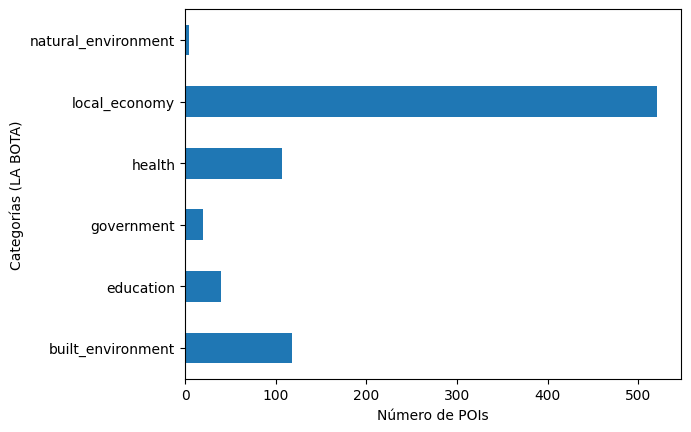

In [52]:
# Gráfico 1
cat_BOTA = POIS[POIS['zona_estudio'] == 'LA BOTA'].groupby(['category'])['name'].count()
ax1 = cat_BOTA.plot(kind='barh')
ax1.set_xlabel('Número de POIs')
ax1.set_ylabel('Categorías (LA BOTA)')

Text(0, 0.5, 'Subcategorías (LA BOTA)')

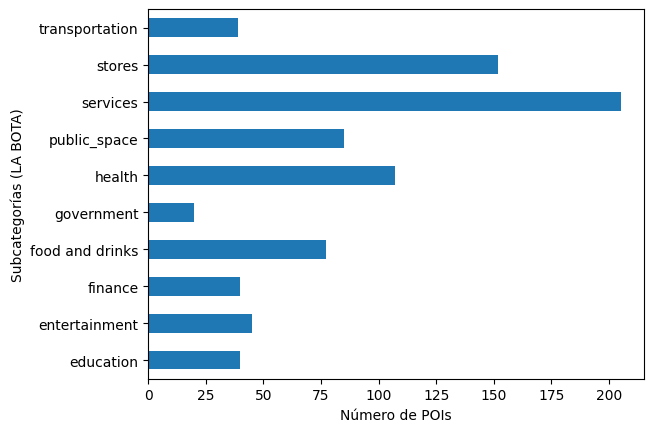

In [53]:
# Gráfico 2
subcat_BOTA = POIS[POIS['zona_estudio'] == 'LA BOTA'].groupby(['sub_cat'])['name'].count()
ax1 = subcat_BOTA.plot(kind='barh')
ax1.set_xlabel('Número de POIs')
ax1.set_ylabel('Subcategorías (LA BOTA)')

Text(0, 0.5, 'Categorías (TOCTIUCO)')

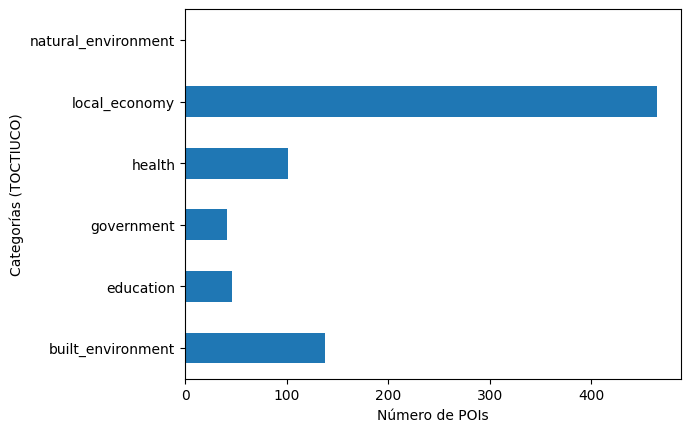

In [54]:
# Gráfico 3
cat_TOC = POIS[POIS['zona_estudio'] == 'TOCTIUCO'].groupby(['category'])['name'].count()
ax2 = cat_TOC.plot(kind='barh')
ax2.set_xlabel('Número de POIs')
ax2.set_ylabel('Categorías (TOCTIUCO)')

Text(0, 0.5, 'Subcategorías (TOCTIUCO)')

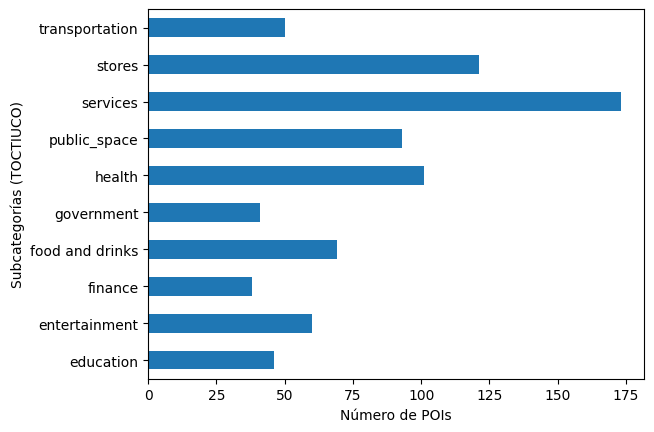

In [55]:
# Gráfico 4
subcat_TOC = POIS[POIS['zona_estudio'] == 'TOCTIUCO'].groupby(['sub_cat'])['name'].count()
ax1 = subcat_TOC.plot(kind='barh')
ax1.set_xlabel('Número de POIs')
ax1.set_ylabel('Subcategorías (TOCTIUCO)')

In [56]:
# Convertir latitud y longitud a radianes
POIS['lat_rad'] = np.radians(POIS['lat'])
POIS['lon_rad'] = np.radians(POIS['lon'])

#Subset de zonas
TOCTIUCO = POIS[POIS['zona_estudio'] == 'TOCTIUCO']
LA_BOTA = POIS[POIS['zona_estudio'] == 'LA BOTA']

In [105]:
# Crear matriz de distancias
dist_matrix_bota = np.zeros((len(LA_BOTA), len(LA_BOTA)))
for i in range(len(LA_BOTA)):
    for j in range(i, len(LA_BOTA)):
        lat1, lon1 = LA_BOTA.loc[i, 'lat_rad'], LA_BOTA.loc[i, 'lon_rad']
        lat2, lon2 = LA_BOTA.loc[j, 'lat_rad'], LA_BOTA.loc[j, 'lon_rad']
        dist = distance((lat1, lon1), (lat2, lon2)).km
        dist_matrix_bota[i,j] = dist
        dist_matrix_bota[j,i] = dist

In [107]:
dist_matrix_bota

array([[0.        , 0.02463975, 0.00282776, ..., 0.02031936, 0.01487641,
        0.01002298],
       [0.02463975, 0.        , 0.0266829 , ..., 0.00685903, 0.0203535 ,
        0.01737197],
       [0.00282776, 0.0266829 , 0.        , ..., 0.02276   , 0.0176706 ,
        0.0108441 ],
       ...,
       [0.02031936, 0.00685903, 0.02276   , ..., 0.        , 0.01357943,
        0.01559094],
       [0.01487641, 0.0203535 , 0.0176706 , ..., 0.01357943, 0.        ,
        0.01799006],
       [0.01002298, 0.01737197, 0.0108441 , ..., 0.01559094, 0.01799006,
        0.        ]])

### NETWORK ANALYSIS

In [11]:
# retrieve street network data for Quito, Ecuador
city = "Quito, Ecuador"
place = ox.geocode_to_gdf(city)
G_drive = ox.graph_from_polygon(place.geometry.iloc[0], network_type="drive")
#G_walk = ox.graph_from_polygon(place.geometry.iloc[0], network_type="walk")
#G_all_private = ox.graph_from_polygon(place.geometry.iloc[0], network_type="all_private")
#G_bike = ox.graph_from_polygon(place.geometry.iloc[0], network_type="bike")

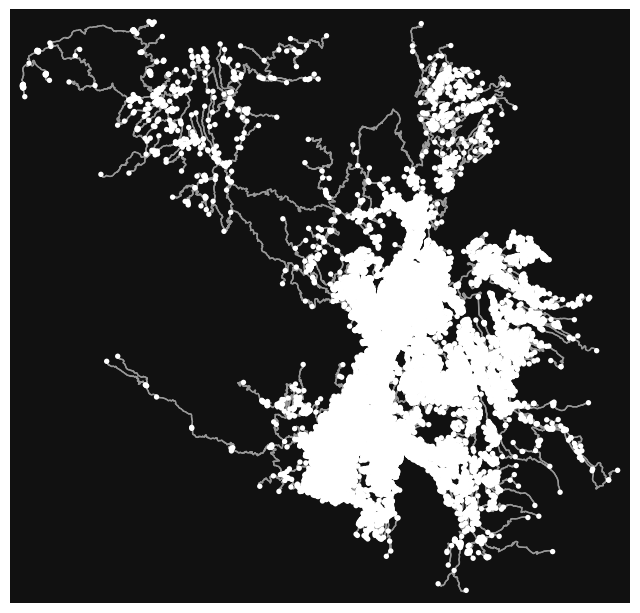

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [12]:
ox.plot_graph(G_drive)

In [129]:
#Convert geometry column in shapely format

POIS['geometry'] = POIS['geometry'].apply(lambda x: loads(x)) 

In [20]:
def get_nearest_node(lat, lon):
    return ox.distance.nearest_nodes(G_drive, lon, lat)
POIS["nearest_node"] = POIS.apply(lambda row: get_nearest_node(row["lat"], row["lon"]), axis=1)


In [13]:
# crea una lista de tuplas con las coordenadas de los POIs
coords = list(zip(POIS['lat'], POIS['lon']))

# encuentra el nodo más cercano a cada punto en la lista de coordenadas
nearest_nodes = ox.distance.nearest_nodes(G_drive, X=[coord[0] for coord in coords], Y=[coord[1] for coord in coords])

# agrega los nodos más cercanos a la tabla de POIs
POIS['nearest_node'] = nearest_nodes

In [21]:
POIS.head(20)

geometry       lat        lon  \
0          POINT (-78.4573401 -0.1099149) -0.109915 -78.457340   
1          POINT (-78.4652594 -0.1198871) -0.119887 -78.465259   
2          POINT (-78.4575256 -0.1084616) -0.108462 -78.457526   
3   POINT (-78.46539229999999 -0.1229637) -0.122964 -78.465392   
4          POINT (-78.4533703 -0.1075254) -0.107525 -78.453370   
5           POINT (-78.452833 -0.1078888) -0.107889 -78.452833   
6          POINT (-78.4535535 -0.1061874) -0.106187 -78.453553   
7           POINT (-78.467528 -0.1241037) -0.124104 -78.467528   
8            POINT (-78.453364 -0.104081) -0.104081 -78.453364   
9          POINT (-78.4549681 -0.0956055) -0.095605 -78.454968   
10         POINT (-78.4598705 -0.1156888) -0.115689 -78.459870   
11         POINT (-78.4595312 -0.1160554) -0.116055 -78.459531   
12         POINT (-78.4600634 -0.1157796) -0.115780 -78.460063   
13         POINT (-78.4604425 -0.1153647) -0.115365 -78.460442   
14          POINT (-78.4582332 -0.115923) -0.115923 -78.458233   
15         POINT (-78.4568805 -0.1170998) -0.117100 -78.456880   
16         POINT (-78.4554417 -0.1182694) -0.118269 -78.455442   
17         POINT (-78.4634084 -0.1190248) -0.119025 -78.463408   
18         POINT (-78.4626435 -0.1198658) -0.119866 -78.462643   
19          POINT (-78.463628 -0.1118362) -0.111836 -78.463628   

                            name  rating           type zona_estudio  \
0                      Mayflower     4.1     restaurant      LA BOTA   
1   Los Encebollados de Panchito     4.5     restaurant      LA BOTA   
2                      Ch Farina     4.2     restaurant      LA BOTA   
3          La casucha del manaba     4.5     restaurant      LA BOTA   
4            Pizza Hut Carapungo     4.2  meal_delivery      LA BOTA   
5   Los Ceviches de la Rumiñahui     4.1     restaurant      LA BOTA   
6             La Ramada Manabita     4.6     restaurant      LA BOTA   
7                        Cai Lin     4.3     restaurant      LA BOTA   
8                            KFC     4.0  meal_takeaway      LA BOTA   
9                  Delma Gourmet     4.2     restaurant      LA BOTA   
10     POLLO HORNEADO MY CHICKEN     4.0     restaurant      LA BOTA   
11                    King Pollo     NaN     restaurant      LA BOTA   
12     Cevicheria Sazon Manabita     4.4     restaurant      LA BOTA   
13              Horno de matilde     4.5     restaurant      LA BOTA   
14        Panificadora + Que Pan     4.5         bakery      LA BOTA   
15            Pescaderia La Bota     4.3     restaurant      LA BOTA   
16                    Ké Pinchos     3.0     restaurant      LA BOTA   
17     Restaurante Comida Típica     NaN     restaurant      LA BOTA   
18          Encebollados Tiburón     5.0     restaurant      LA BOTA   
19            Tilapias Chavelita     4.8     restaurant      LA BOTA   

         category sub_cat   lat_rad   lon_rad  nearest_node  
0   local_economy    food -0.001918 -1.369339    4243047262  
1   local_economy    food -0.002092 -1.369477     297952123  
2   local_economy    food -0.001893 -1.369342    4104114544  
3   local_economy    food -0.002146 -1.369479     297966519  
4   local_economy    food -0.001877 -1.369270    2914672195  
5   local_economy    food -0.001883 -1.369260    2919664145  
6   local_economy    food -0.001853 -1.369273    2914674733  
7   local_economy    food -0.002166 -1.369517    1669414782  
8   local_economy    food -0.001817 -1.369270    4268706160  
9   local_economy    food -0.001669 -1.369298     302582127  
10  local_economy    food -0.002019 -1.369383     297952290  
11  local_economy    food -0.002026 -1.369377     297952281  
12  local_economy    food -0.002021 -1.369386     297952289  
13  local_economy    food -0.002013 -1.369393     297952296  
14  local_economy    food -0.002023 -1.369354     297952239  
15  local_economy    food -0.002044 -1.369331     297952192  
16  local_economy    food -0.002064 -1.369306     297952167  
17  local_economy

In [22]:
#nodos por zonas
nodes_toctiuco = list(POIS[POIS['zona_estudio'] == 'TOCTIUCO']['nearest_node'].unique())
nodes_bota = list(POIS[POIS['zona_estudio'] == 'LA BOTA']['nearest_node'].unique())

In [30]:
type(nodes_toctiuco)

list

In [33]:
subgrafo_toc = G_drive.subgraph(nodes_toctiuco)
subgrafo_bota = G_drive.subgraph(nodes_bota)

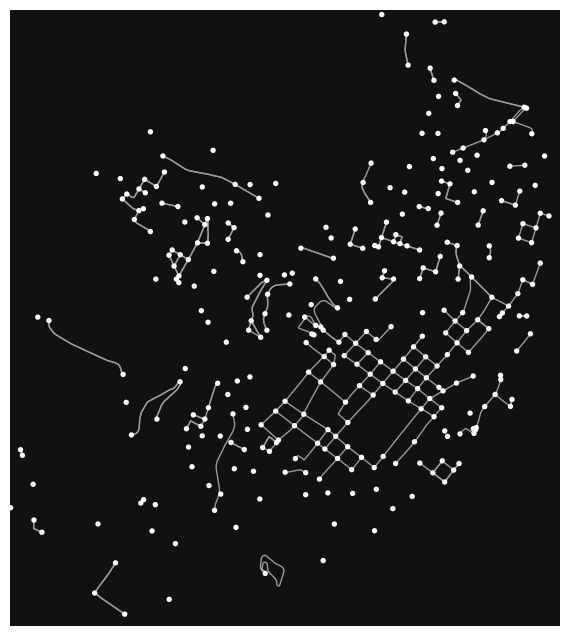

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [32]:
ox.plot_graph(subgrafo_toc)

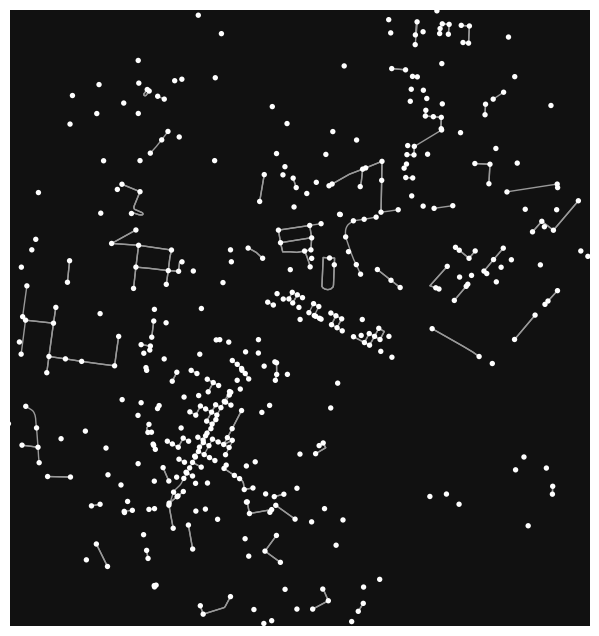

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [34]:
ox.plot_graph(subgrafo_bota)

In [35]:
ox.basic_stats(subgrafo_bota)

{'n': 478,
 'm': 415,
 'k_avg': 1.7364016736401673,
 'edge_length_total': 39797.74400000003,
 'edge_length_avg': 95.89817831325308,
 'streets_per_node_avg': 3.0543933054393304,
 'streets_per_node_counts': {0: 0, 1: 47, 2: 0, 3: 314, 4: 114, 5: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09832635983263599,
  2: 0.0,
  3: 0.6569037656903766,
  4: 0.2384937238493724,
  5: 0.006276150627615063},
 'intersection_count': 431,
 'street_length_total': 22665.76800000001,
 'street_segment_count': 241,
 'street_length_avg': 94.04882987551872,
 'circuity_avg': 1.043794625356246,
 'self_loop_proportion': 0.0}

### ANALYSIS OF PROXIMITY NETWORK
#### 10 mas cercanos 

In [88]:
category = 'local_economy'
local_eco_bota = POIS[(POIS['category'] == category) &
                      (POIS['zona_estudio'] == 'LA BOTA')]

In [89]:
# Cálculo de las distancias entre POIs
def distancia(coord1, coord2):
    return geodesic(coord1, coord2).meters

coordenadas = local_eco_bota[['lat', 'lon']].to_numpy()
n_pois = coordenadas.shape[0]
distancias = np.zeros((n_pois, n_pois))
for i in range(n_pois):
    for j in range(i+1, n_pois):
        dist = distancia(coordenadas[i], coordenadas[j])
        distancias[i,j] = dist
        distancias[j,i] = dist

In [77]:
type(distancias)

numpy.ndarray

In [90]:
# Selección de los 10 POIs más cercanos para cada POI
indices_cercanos = np.argsort(distancias, axis=1)[:, 1:11]


In [91]:
# Creación de la matriz de adyacencia
adyacencia = np.zeros((n_pois, n_pois))
for i in range(n_pois):
    adyacencia[i, indices_cercanos[i]] = 1
    adyacencia[indices_cercanos[i], i] = 1

In [92]:
# Creación del grafo y análisis de la red
G = nx.from_numpy_array(adyacencia)
print(f'Número de nodos: {G.number_of_nodes()}')
print(f'Número de aristas: {G.number_of_edges()}')
print(f'Grado medio: {np.mean([G.degree(n) for n in G.nodes])}')

Número de nodos: 521
Número de aristas: 3361
Grado medio: 12.9021113243762


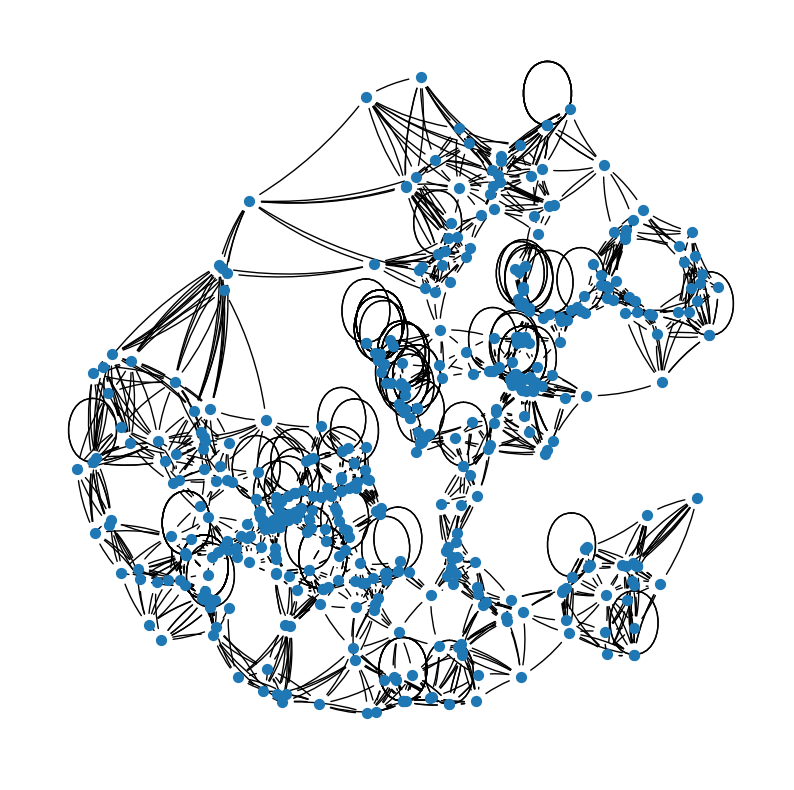

In [93]:
# Visualización del grafo
plt.figure(figsize=(10,10))
pos = dict(zip(range(n_pois), coordenadas))
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, width=1, connectionstyle='arc3,rad=0.1', arrows=True)
plt.axis('off')
plt.show()


C:\Users\diana\AppData\Local\Temp\ipykernel_45040\1477985614.py:8: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, connectionstyle='arc3,rad=0.1')


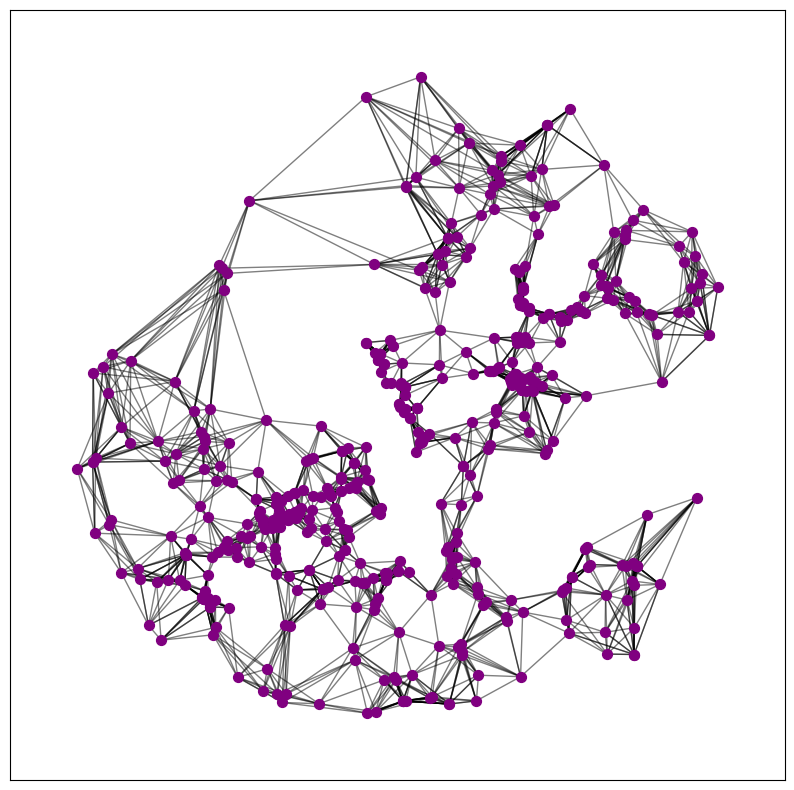

In [98]:
# Eliminar ciclos
G.remove_edges_from(nx.selfloop_edges(G))

# Visualización del grafo
plt.figure(figsize=(10,10))
pos = dict(zip(range(n_pois), coordenadas))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='purple')
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, connectionstyle='arc3,rad=0.1')
plt.axis('on')
plt.show()

In [106]:
# Restablecer el índice del DataFrame
local_eco_bota = local_eco_bota.reset_index(drop=True)

# Coordenadas de los nodos
coordenadas = local_eco_bota[['lat', 'lon']].values.tolist()

# Creación del mapa
mapa = folium.Map(location=[coordenadas[0][0], coordenadas[0][1]], zoom_start=14)

# FeatureGroup para nodos
fg_nodos = folium.FeatureGroup(name='POIs')
for i in range(len(coordenadas)):
    folium.Marker(location=coordenadas[i], tooltip=local_eco_bota.loc[i, 'name'],
                  icon=folium.Icon(color='purple')).add_to(fg_nodos)

# FeatureGroup para aristas
fg_aristas = folium.FeatureGroup(name='Conexiones')
for edge in G.edges:
    coords = [coordenadas[edge[0]], coordenadas[edge[1]]]
    folium.PolyLine(coords, color='black', weight=1).add_to(fg_aristas)

# Agregar FeatureGroups al mapa
mapa.add_child(fg_nodos)
mapa.add_child(fg_aristas)
folium.LayerControl().add_to(mapa)


In [107]:
mapa